# virtueller Requirements Engineer Experiment
https://parts-of-speech.info

In [1]:
import os

In [2]:
data_dir = "/Users/vs21/hicss23/Data/"
data_files = []

for file_name in os.listdir(data_dir):
    if ".txt" in file_name:
        data_files.append(data_dir + file_name)

data_files


['/Users/vs21/hicss23/Data/akita_3.txt',
 '/Users/vs21/hicss23/Data/akita_2.txt',
 '/Users/vs21/hicss23/Data/akita_1.txt',
 '/Users/vs21/hicss23/Data/akita_4.txt']

In [3]:
data_content = []
for data_file in data_files:
    with open (data_file, 'r') as file:
        data_content.append(file.read().replace('\n', '').replace('.', ' ').replace(',', ' '))

In [4]:
data_content[2]

'The Akita (秋田  Akita  Japanese pronunciation: [akʲita]) is a Japanese dog breed of large size  Originating from the mountains of northern Japan  the Akita has a short double coat similar to that of many other northern spitz breeds  Historically  they were used by samurai for guarding  fighting and the hunting of bears The Akita is a powerful  independent  and dominant breed  commonly aloof with strangers  but affectionate and deeply loyal with its family  As a breed  Akitas are generally hardy  The two separate varieties of Akita are a pure Japanese strain  called Akita Inu or Akita-ken  and a larger mixed strain  commonly referred to as the "American Akita" [2] However  it is subject to debate as to whether the Akita strains are distinct  or if they constitute one  single breed [3][4][5]Debate exists among fanciers whether these are two separate breeds of Akitas  As of 2020  the American Kennel Club [6] now considers American and Japanese Akitas to be two separate breeds  no longer a

### stanford core nlp
method receives a sentence and returns : Normal Text, lemmatized text, POS.

In [5]:
import stanza
stanza.download('en')       # This downloads the English models for the neural pipeline
nlp = stanza.Pipeline('en', processors='tokenize,pos,lemma,depparse') # This sets up a default neural pipeline in English


2023-06-12 22:44:05 INFO: Downloading default packages for language: en (English) ...
2023-06-12 22:44:06 INFO: File exists: /Users/vs21/stanza_resources/en/default.zip
2023-06-12 22:44:09 INFO: Finished downloading models and saved to /Users/vs21/stanza_resources.
2023-06-12 22:44:09 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-06-12 22:44:09 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2023-06-12 22:44:09 INFO: Use device: cpu
2023-06-12 22:44:09 INFO: Loading: tokenize
2023-06-12 22:44:09 INFO: Loading: pos
2023-06-12 22:44:10 INFO: Loading: lemma
2023-06-12 22:44:10 INFO: Loading: depparse
2023-06-12 22:44:10 INFO: Done loading processors!


In [6]:
test_sentence = "Documents contained the Name of the consultant."
def core_nlp(sentence):
    # method receives a sentence and returns : Normal Text, lemmatized text, POS.
    result_list = []
    doc = nlp(sentence)
    for sentence in doc.sentences:
        for word in sentence.words:
            result_list.append([word.text, word.lemma, word.pos, word.deprel, word.head])
            # deprel doku : https://stanfordnlp.github.io/stanza/depparse.html
    return result_list


In [7]:
nlp_results = []
for content in data_content:
    nlp_results.append(core_nlp(content))

len(nlp_results)

4

### get all nouns (potential candidates for classes)
extracted from the original text

In [8]:
def get_all_nouns(nlp_results):
    nouns = []
    for word in nlp_results:
        normal_word = word[0]
        lemma_word = word[1]
        pos_word = word[2]
        deprel_word = word[3]
        if pos_word == "NOUN":
            nouns.append(lemma_word)
    return list(set(nouns))

In [9]:
data_nouns = []
for result in nlp_results:
    data_nouns.append(get_all_nouns(result))

len(data_nouns)

4

In [10]:
len(data_nouns[3])

114

In [11]:
data_nouns[3]

['terrain',
 'gait',
 'length',
 'station',
 'weather',
 'luxation',
 'eye',
 'pemphigus',
 'work',
 'recognition',
 'hair',
 'leash',
 'vkh',
 'anemia',
 'family',
 'training',
 'spitz',
 'cell',
 'onion',
 'hiking',
 'serviceman',
 'ceremony',
 'yearsNote',
 'span',
 'trait',
 'police',
 'build',
 'insulation',
 'epilepsy',
 'size',
 'bone',
 'polyneuropathy',
 'household',
 'exercise',
 'elbow',
 'representative',
 'companion',
 'rupture',
 'thyroidLife',
 'jog',
 'patellar',
 'pinto',
 'undercoat',
 'hypothyroidismoccasionally',
 'akc',
 'body',
 'healthmajor',
 'pra',
 'hypoplasia',
 'dysplasia',
 'admirer',
 'ligament',
 'game',
 'water',
 'akita',
 'type',
 'adenitis',
 'concern',
 'inch',
 'member',
 'popularity',
 'lymphosarcoma',
 'entropion',
 'time',
 'osteosarcoma',
 'tomb',
 'loyalty',
 'century',
 'dog',
 'coat',
 'hand',
 'combination',
 'cruciate',
 'homage',
 'hip',
 'blood',
 'syndrome',
 'drinker',
 'house',
 'mask',
 'breeder',
 'pet',
 'week',
 'evening',
 'day',


# One hot encoding

In [12]:
all_nouns = [elem for sublist in data_nouns for elem in sublist]
vocabulary = list(set([elem for sublist in data_nouns for elem in sublist]))
len(vocabulary)

540

In [13]:
# mutual nouns:

len(all_nouns) - len(list(set(vocabulary)))


189

In [14]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def integer_encoding(vocab):
    # function that takes a list of strings + the entire vocabulary and outputs a one hot encoding
    values = array(vocab)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    return {values[i]:integer_encoded[i] for i, val in enumerate(vocab)}



In [15]:
encoding = integer_encoding(vocabulary)

In [16]:
len(encoding)

540

In [17]:
def create_one_hot_vector(input_data, encoding):
    # create empty vector
    collect = [0 for i in range(len(encoding))]
    for word in input_data:
        collect[encoding[word]] = 1
    return collect

In [18]:
input_data = ["toy", "toy"]
# input_data = data_nouns[3]

test_function = create_one_hot_vector(input_data, encoding)
test_function.count(1)
# test_function.count(0)

1

# Distance between two one hot vectors

In [19]:
import numpy as np
from numpy.linalg import norm

X = np.array(create_one_hot_vector(["evening", "mask"], encoding))
Y = np.array(create_one_hot_vector(["toy", "homage"], encoding))

cosine = np.dot(X,Y)/(norm(X)*norm(Y))
cosine

0.0

In [20]:
def get_distance(X, Y):
    return np.dot(X,Y)/(norm(X)*norm(Y))

get_distance(X,Y)

0.0

# Requirement Engineer

In [75]:
class r_engineer:
    def __init__(self, nouns):
        self.nouns = nouns
    
    def get_nouns(self):
        return self.nouns

    def get_mutual_nouns(self, customer_nouns):
        return list(set(customer_nouns).intersection(self.nouns))
    
    def append_to_own_nouns(self, final_nouns):
        self.nouns = list(set(self.nouns + final_nouns))


In [76]:
r_eng = r_engineer(data_nouns[2])

# r_eng.get_nouns()
mutual_nouns = r_eng.get_mutual_nouns(data_nouns[1])
len(mutual_nouns)

41

# Customer

In [77]:
class customer:
    def __init__(self, nouns, name):
        self.nouns = nouns
        self.name = name
    
    def get_nouns(self):
        return self.nouns
    
    def create_final_nouns(self, mutual_nouns):
        final_nouns = mutual_nouns
        self.final_nouns = list(set(final_nouns))

        return self.final_nouns
    
    def append_to_final_nouns(self, r_eng_nouns, cooperation_factor):
        self.final_nouns = list(set(self.final_nouns + r_eng_nouns[:int(len(r_eng_nouns) * cooperation_factor)]))
        # self.nouns = list(set(self.final_nouns + r_eng_nouns[:int(len(r_eng_nouns) * cooperation_factor)]))
        return self.final_nouns
    
    


In [78]:
customer_1 = customer(data_nouns[0], "customer_1")
customer_2 = customer(data_nouns[1], "customer_2")
customer_3 = customer(data_nouns[3], "customer_3")

print(customer_1.nouns)
print(customer_2.nouns)
print(customer_3.nouns)

len(customer_1.nouns)

final_nouns = customer_1.create_final_nouns(["bmw"])
print(len(final_nouns))

final_nouns = customer_1.append_to_final_nouns(["test" + str(i) for i in range(10)], 1)
print(len(final_nouns))

['averagelongevity', 'tail', 'length', 'friend', 'color', 'chow', 'energy', 'expression', 'growth', 'eye', 'patch', 'visit', 'person', 'ear', 'hunting', 'home', 'neck', 'hair', 'family', 'training', 'bearsCoat', 'puppy', 'child', 'pound', 'grooming', 'police', 'protection', 'herd', 'companionship', 'expectation', 'pair', 'need', 'snore', 'size', 'triangle', 'cost', 'climate', 'leader', 'ability', 'level', 'mediumcharacteristics', 'companion', 'addition', 'company', 'name', 'age', 'tendency', 'moderatebred', 'pinto', 'undercoat', 'gesture', 'weight', 'happiness', 'akc', 'averageenergy', 'classification', 'body', 'base', 'aggression', 'strength', 'show', 'cat', 'head', 'life', 'course', 'country', 'lb', 'game', 'workingukc', 'Exercise', 'group', 'moderateclub', 'coatColor', 'care', 'inch', 'member', 'popularity', 'Range', 'background', 'requirement', 'history', 'characteristic', 'instinct', 'loyalty', 'century', 'dog', 'room', 'symbol', 'coat', 'crossing', 'prevalence', 'personality', 'b

# Interaction

### pseudocode:

    def interaction(r_engineer (obj), customer (obj), cooperation_factor):
        customer_nouns = customer.get_nouns()
        mutual_nouns = r_engineer.get_mutual_Nouns(customer_nouns)
        final_nouns = customer.create_final_nouns(mutual_nouns)
        r_engineer_nouns = r_engineer.get_nouns()
        final_nouns = customer.append_to_final_nouns(r_engineer_nouns, cooperation_factor)

        return final_nouns # list with nouns

In [79]:
customer_1 = customer(data_nouns[0], "customer_1")
r_eng = r_engineer(data_nouns[2])

In [80]:
print(len(customer_1.nouns))
print(len(r_eng.nouns))
print(len(r_eng.nouns) + len(customer_1.nouns))

139
347
486


In [81]:
def interaction(r_engineer, customer, cooperation_factor):
    customer_nouns = customer.get_nouns()
    mutual_nouns = r_engineer.get_mutual_nouns(customer_nouns)
    final_nouns = customer.create_final_nouns(mutual_nouns)
    r_engineer_nouns = r_engineer.get_nouns()
    final_nouns = customer.append_to_final_nouns(r_engineer_nouns, cooperation_factor)
    r_engineer.append_to_own_nouns(final_nouns)

    return final_nouns, r_engineer.get_nouns(), customer.get_nouns()

final_nouns, r_engineer_nouns, customer_nouns = interaction(r_eng, customer_1, 1)

In [82]:
print(len(final_nouns))
print(len(customer_nouns))
print(len(r_eng.nouns))
print(len(r_engineer_nouns))


347
139
347
347


In [83]:
print(len(final_nouns))
print(len(customer_nouns))
print(len(r_eng.nouns))
print(len(r_engineer_nouns))


347
139
347
347


# Experiment

In [84]:
cooperation_factors = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
cooperation_factors

[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [85]:
r_eng = r_engineer(data_nouns[2])

customer_1 = customer(data_nouns[0], "customer_1")
customer_2 = customer(data_nouns[1], "customer_2")
customer_3 = customer(data_nouns[3], "customer_3")
customers = [customer_1, customer_2, customer_3]

In [86]:
customer_1.__class__.__name__
customer_1.name

'customer_1'

In [87]:
collect = []

for customer in customers:
    for cp in cooperation_factors:
        r_eng = r_engineer(data_nouns[2]) # initiliaze re eng 
        interaction_nouns, r_engineer_nouns, customer_nouns = interaction(r_eng, customer, cp)
        result_vector = create_one_hot_vector(interaction_nouns, encoding)
        r_eng_vector = create_one_hot_vector(r_engineer_nouns, encoding)
        customer_vector = create_one_hot_vector(customer_nouns, encoding)
        collect.append({"customer": customer.name, "cp": cp, "result_vector": result_vector, "r_eng_vector": r_eng_vector, "customer_vector": customer_vector})

In [88]:
len(collect)

33

In [89]:
collect[0]["customer"]

'customer_1'

In [90]:
test = []
for element in collect:
    if len(element["result_vector"]) not in test:
        test.append(len(element["result_vector"]))

print(test)

[540]


In [91]:
collect[6]["r_eng_vector"].count(1)

347

# analyze results

In [92]:
def analyze_result_vector(first, second, cp):

    for element in collect:
        if element["customer"] == first and element["cp"] == cp:
            vector_1 = element["result_vector"]
        if element["customer"] == second and element["cp"] == cp:
            vector_2 = element["result_vector"]
            
    return get_distance(np.array(vector_1), np.array(vector_2))

In [93]:
# analyze final subjects and plot them
X = [[], [], []] # three list for the three comparisions
Y = [[], [], []]

for cp in cooperation_factors:
    # compare customer_1 - customer_2
    Y[0].append(cp)
    X[0].append(analyze_result_vector("customer_1", "customer_2", cp))

    # compare customer_1 - customer_3
    Y[1].append(cp)
    X[1].append(analyze_result_vector("customer_1", "customer_3", cp))

    # compare customer_2 - customer_3
    Y[2].append(cp)
    X[2].append(analyze_result_vector("customer_2", "customer_3", cp))

In [94]:
Y[0]

[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [95]:
X[0]

[0.44214420766255563,
 0.684353203432982,
 0.7987467527449464,
 0.8793793930662117,
 0.9104547758363141,
 0.9360628142560785,
 0.9508562893486828,
 0.9639902572269998,
 0.9760502923095318,
 0.9875389408099688,
 1.0]

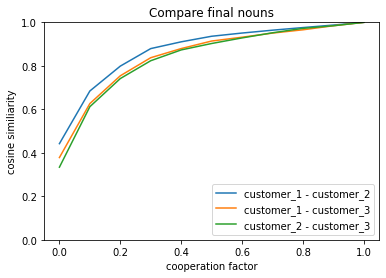

In [96]:
import matplotlib.pyplot as plt

plt.ylabel("cosine similiarity")
plt.xlabel("cooperation factor")

plt.legend([])
plt.title("Compare final nouns")

plt.plot(Y[0], X[0], label="customer_1 - customer_2")
plt.plot(Y[1], X[1], label="customer_1 - customer_3")
plt.plot(Y[2], X[2], label="customer_2 - customer_3")

plt.legend(loc="lower right")
plt.ylim(0, 1.0)

plt.savefig("/Users/vs21/Desktop/compare_final.png", dpi=900)
plt.show()

In [97]:
print(collect[0]["customer_vector"])

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 

In [98]:
print(collect[9]["customer_vector"])

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 

In [99]:
def analyze_participants_vector(reference_customer, cp):

    for element in collect:
        if element["customer"] == reference_customer and element["cp"] == cp:
            vector_1 = element["customer_vector"]
            vector_2 = element["r_eng_vector"]
            
    
    return get_distance(np.array(vector_1), np.array(vector_2))

In [100]:
# analyze final subjects and plot them
X = [[], [], []] # three list for the three comparisions
Y = [[], [], []]

for cp in cooperation_factors:
    
    Y[0].append(cp)
    X[0].append(analyze_participants_vector("customer_1", cp))
    # ...
    Y[1].append(cp)
    X[1].append(analyze_participants_vector("customer_2", cp))
    # ...
    Y[2].append(cp)
    X[2].append(analyze_participants_vector("customer_3", cp))

In [101]:
X[0]

[0.3005189051982662,
 0.3005189051982662,
 0.3005189051982662,
 0.3005189051982662,
 0.3005189051982662,
 0.3005189051982662,
 0.3005189051982662,
 0.3005189051982662,
 0.3005189051982662,
 0.3005189051982662,
 0.3005189051982662]

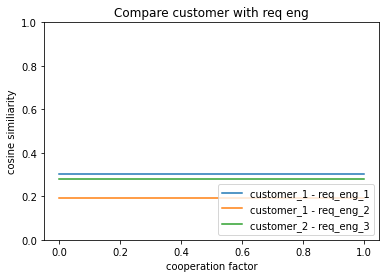

In [102]:
import matplotlib.pyplot as plt

plt.ylabel("cosine similiarity")
plt.xlabel("cooperation factor")

plt.legend([])
plt.title("Compare customer with req eng")

plt.plot(Y[0], X[0], label="customer_1 - req_eng_1")
plt.plot(Y[1], X[1], label="customer_1 - req_eng_2")
plt.plot(Y[2], X[2], label="customer_2 - req_eng_3")

plt.legend(loc="lower right")
plt.ylim(0, 1.0)

plt.savefig("/Users/vs21/Desktop/compare_single.png", dpi=900)
plt.show()